In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tabnet
import pandas_datareader
import datetime
from sklearn.preprocessing import MinMaxScaler


In [49]:
pre_days = 1
mem_his_days = 5
epoch = 50
batch_size = 64

In [50]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 9, 1)

feature = pandas_datareader.data.DataReader('GOOGL', 'stooq', start, end)
feature.dropna(inplace=True)
feature.sort_index(inplace=True)

origin_col_names = ['Volume', 'Open', 'High', 'Low']
column = list()
for col in origin_col_names:
    for idx in range(pre_days, pre_days + mem_his_days):
        new_col = col + '-' + str(idx)
        feature[new_col] = feature[col].shift(idx)
        column.append(new_col)
    feature = feature.drop(columns=col, axis=1)
feature['PreClose'] = feature['Close'].shift(1)
feature['Change'] = feature['Close'] / feature['PreClose']
feature['Change'] = feature['Change'].apply(lambda x: 1 if x > 1 else 0)
feature = feature.drop(columns='PreClose', axis=1)
feature = feature.drop(columns='Close', axis=1)
feature = feature.dropna()
label = feature['Change']
feature = feature.drop(columns='Change', axis=1)

print(feature.head(10))
feature = np.array(feature).astype('float32')

print(column)
print(feature)
print(label)

feature_columns = []
for col_name in column:
    feature_columns.append(tf.feature_column.numeric_column(col_name))
print(feature_columns)

ds = tf.data.Dataset.from_tensor_slices((feature, label))
print(ds)

def transform(features, labels):
    y = tf.one_hot(labels, 2)
    x = dict(zip(column, tf.unstack(features)))
    return x, y

total_size = len(ds)
train_size = int(total_size * 0.9)

ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_train = ds_train.map(transform).shuffle(train_size).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(transform).shuffle(total_size - train_size).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)
print(len(ds_train), ds_train)
print(len(ds_test), ds_test)

               Volume-1     Volume-2     Volume-3     Volume-4     Volume-5  \
Date                                                                          
2004-08-26  183956000.0  305252000.0  365488000.0  457144000.0  894076000.0   
2004-08-27  142040000.0  183956000.0  305252000.0  365488000.0  457144000.0   
2004-08-30  124360000.0  142040000.0  183956000.0  305252000.0  365488000.0   
2004-08-31  104040000.0  124360000.0  142040000.0  183956000.0  305252000.0   
2004-09-01   98456000.0  104040000.0  124360000.0  142040000.0  183956000.0   
2004-09-02  182948000.0   98456000.0  104040000.0  124360000.0  142040000.0   
2004-09-03  302676000.0  182948000.0   98456000.0  104040000.0  124360000.0   
2004-09-07  103152000.0  302676000.0  182948000.0   98456000.0  104040000.0   
2004-09-08  117068000.0  103152000.0  302676000.0  182948000.0   98456000.0   
2004-09-09   99812000.0  117068000.0  103152000.0  302676000.0  182948000.0   

             Open-1   Open-2   Open-3   Open-4   Op

In [51]:
# Group Norm does better for small datasets
model = tabnet.TabNetClassifier(feature_columns, num_classes=2, num_features=len(column),
                                feature_dim=20, output_dim=10, num_decision_steps=10, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=20, decay_rate=0.9, staircase=False)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss=loss, metrics=['accuracy'])


history = model.fit(ds_train, epochs=epoch, validation_data=ds_test)

model.summary()

[TabNet]: 10 features will be used for decision steps.
Epoch 1/50
61/61 [==============================] - 23s 63ms/step - loss: 0.7246 - accuracy: 0.5061 - val_loss: 0.7122 - val_accuracy: 0.4219
Epoch 2/50
61/61 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.4968 - val_loss: 0.6816 - val_accuracy: 0.5781
Epoch 3/50
61/61 [==============================] - 1s 14ms/step - loss: 0.6948 - accuracy: 0.4999 - val_loss: 0.6805 - val_accuracy: 0.5781
Epoch 4/50
61/61 [==============================] - 1s 14ms/step - loss: 0.6954 - accuracy: 0.4978 - val_loss: 0.7074 - val_accuracy: 0.4242
Epoch 5/50
61/61 [==============================] - 1s 15ms/step - loss: 0.6954 - accuracy: 0.5048 - val_loss: 0.6865 - val_accuracy: 0.5804
Epoch 6/50
61/61 [==============================] - 1s 14ms/step - loss: 0.6943 - accuracy: 0.5004 - val_loss: 0.6841 - val_accuracy: 0.5804
Epoch 7/50
61/61 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5136

{'loss': [0.724635660648346, 0.6968241333961487, 0.6947640180587769, 0.6953789591789246, 0.6953626871109009, 0.6943271160125732, 0.693139910697937, 0.6930940747261047, 0.6930559277534485, 0.6930450201034546, 0.6928439140319824, 0.692930281162262, 0.6926402449607849, 0.6923429369926453, 0.6925041079521179, 0.692477285861969, 0.6923666000366211, 0.6922692060470581, 0.6921959519386292, 0.6922786235809326, 0.6922228932380676, 0.6922078132629395, 0.6921848058700562, 0.692188024520874, 0.6921924948692322, 0.6921767592430115, 0.6921777725219727, 0.6921741366386414, 0.6921753883361816, 0.6921747922897339, 0.6921757459640503, 0.6921717524528503, 0.6921728253364563, 0.692171037197113, 0.6921710968017578, 0.6921718120574951, 0.6921705007553101, 0.6921708583831787, 0.6921703815460205, 0.6921703219413757, 0.692170262336731, 0.6921703219413757, 0.692170262336731, 0.692170262336731, 0.6921703219413757, 0.692170262336731, 0.6921703815460205, 0.692170262336731, 0.6921703815460205, 0.6921702027320862], 

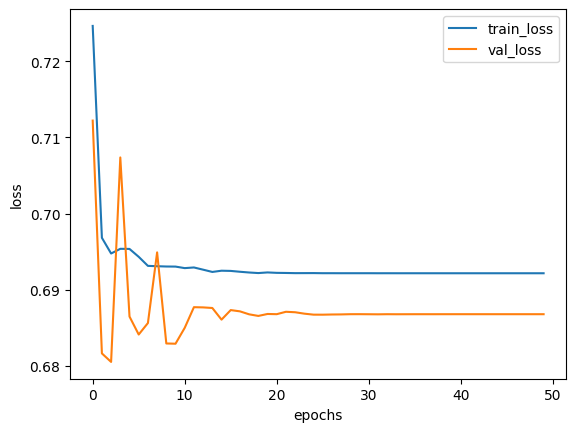

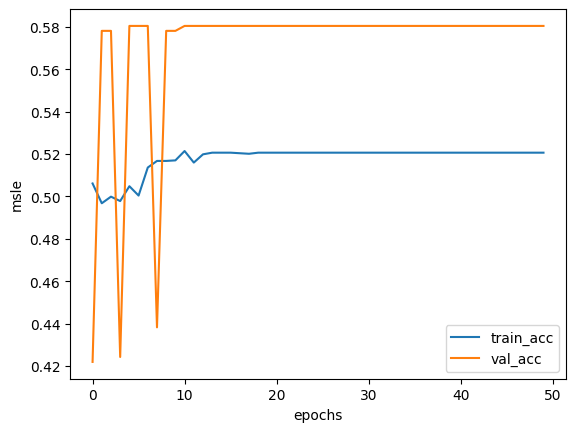

In [52]:
history_dict = history.history
print(history_dict)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.plot(range(epoch), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_acc, label='train_acc')
plt.plot(range(epoch), val_acc, label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()